In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm, skew
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn import ensemble, tree, linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import shuffle
from subprocess import check_output
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [7]:
df_train = pd.read_csv('input/train.csv')
df_test = pd.read_csv('input/test.csv')

In [49]:
#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(df_train.shape))
print("The test data size before dropping Id feature is : {} ".format(df_test.shape))

#Save the 'Id' column
train_ID = df_train['Id']
test_ID = df_test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
df_train.drop("Id", axis = 1, inplace = True)
df_test.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(df_train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(df_test.shape))

The train data size before dropping Id feature is : (1457, 63) 
The test data size before dropping Id feature is : (1459, 80) 

The train data size after dropping Id feature is : (1457, 62) 
The test data size after dropping Id feature is : (1459, 79) 


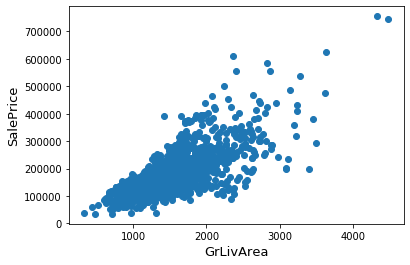

In [51]:
fig, ax = plt.subplots()
ax.scatter(x = df_train['GrLivArea'], y = df_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

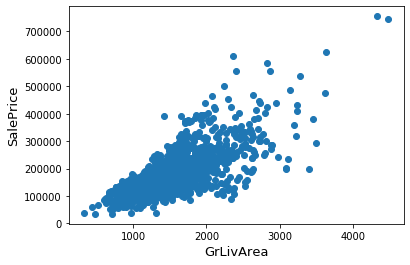

In [52]:
#Deleting outliers
df_train = df_train.drop(df_train[(df_train['GrLivArea']>4000) & (df_train['SalePrice']<300000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(df_train['GrLivArea'], df_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

**Log-transformation of the target variable**


 mu = 12.02 and sigma = 0.40



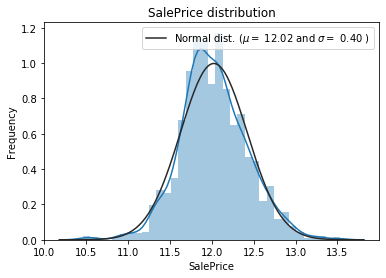

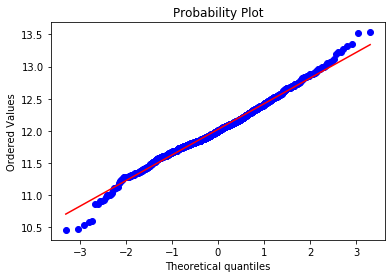

In [53]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])

#Check the new distribution 
sns.distplot(df_train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df_train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)
plt.show()

## Features engineering

In [55]:
ntrain = df_train.shape[0]
ntest = df_test.shape[0]
y_train = df_train.SalePrice.values
all_data = pd.concat((df_train, df_test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2916, 79)


### Missing Data

In [56]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

Missing Ratio
PoolQC            99.897119
MiscFeature       98.251029
Alley             96.330590
Fence             90.054870
FireplaceQu       75.000000
LotFrontage       57.750343
GarageQual        52.640604
GarageCond        52.640604
GarageFinish      52.640604
GarageYrBlt       52.640604
GarageType        52.572016
BsmtCond          51.508916
BsmtQual          51.474623
BsmtExposure      51.474623
BsmtFinType1      51.406036
BsmtFinType2      51.406036
MasVnrType        50.514403
MasVnrArea        50.480110
MSZoning           0.137174
BsmtFullBath       0.068587

Text(0.5, 1.0, 'Percent missing data by feature')

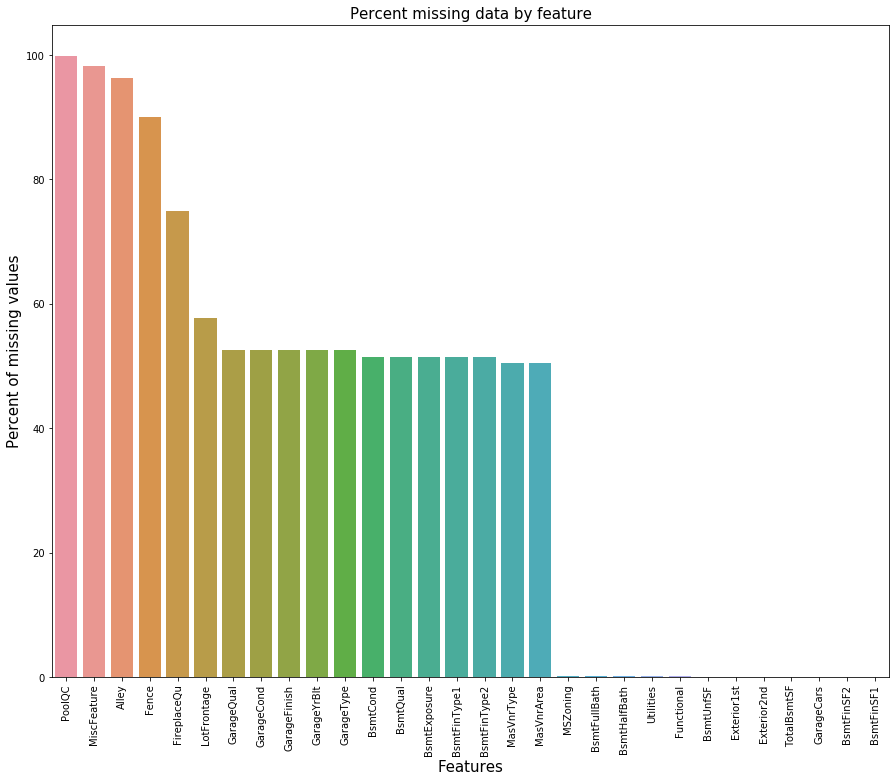

In [57]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

#### Imputing missing values

We impute them by proceeding sequentially through features with missing values

- PoolQC : data description says NA means "No Pool". That make sense, given the huge ratio of missing value (+99%) and majority of houses have no Pool at all in general.

In [58]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

- MiscFeature : data description says NA means "no misc feature"

In [59]:
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

- Alley : data description says NA means "no alley access"

In [60]:
all_data["Alley"] = all_data["Alley"].fillna("None")

- Fence : data description says NA means "no fence"

In [61]:
all_data["Fence"] = all_data["Fence"].fillna("None")

- FireplaceQu : data description says NA means "no fireplace"

In [62]:
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

- LotFrontage : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood.

In [63]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

- GarageType, GarageFinish, GarageQual and GarageCond : Replacing missing data with None

In [64]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

- GarageYrBlt, GarageArea and GarageCars : Replacing missing data with 0 (Since No garage = no cars in such garage.)

In [65]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

- BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath : missing values are likely zero for having no basement

In [66]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

- BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2 : For all these categorical basement-related features, NaN means that there is no basement.

In [67]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

- MasVnrArea and MasVnrType : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type.

In [68]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

- MSZoning (The general zoning classification) : 'RL' is by far the most common value. So we can fill in missing values with 'RL'

In [69]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

- Utilities : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.

In [70]:
all_data = all_data.drop(['Utilities'], axis=1)

- Functional : data description says NA means typical

In [72]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

- Electrical : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.

In [73]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

- KitchenQual: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual.

In [74]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

- Exterior1st and Exterior2nd : Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string

In [75]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

- SaleType : Fill in again with most frequent which is "WD"

In [76]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

- MSSubClass : Na most likely means No building class. We can replace missing values with None

In [77]:
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [78]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

Empty DataFrame
Columns: [Missing Ratio]
Index: []

### More features engeneering

**Transforming some numerical variables that are really categorical**

In [79]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

**Label Encoding some categorical variables that may contain information in their ordering set**

In [80]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2916, 78)


**Adding one more important feature**

Since area related features are very important to determine house prices, we add one more feature which is the total area of basement, first and second floor areas of each house

In [81]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

**Skewed features**

In [82]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



Skew
MiscVal        21.935910
PoolArea       17.685603
LotArea        13.107212
LowQualFinSF   12.082427
3SsnPorch      11.370087
LandSlope       4.972302
KitchenAbvGr    4.299698
BsmtFinSF2      4.143683
EnclosedPorch   4.001570
ScreenPorch     3.944305

**Box Cox Transformation of (highly) skewed features**

We use the scipy function boxcox1p which computes the Box-Cox transformation of  1+x .
Note that setting  λ=0  is equivalent to log1p used above for the target variable.

In [84]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 59 skewed numerical features to Box Cox transform


**Getting dummy categorical features**

In [85]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2916, 219)


In [86]:
#Getting the new train and test sets.
df_train = all_data[:ntrain]
df_test = all_data[ntrain:]

In [92]:
%store df_train
%store df_test
%store y_train
%store test_ID

Stored 'df_train' (DataFrame)
Stored 'df_test' (DataFrame)
Stored 'y_train' (ndarray)
Stored 'test_ID' (Series)


# HZ